# Dependencies
## Imports
Install and import project dependencies

In [14]:
#%pip install matplotlib numpy pandas

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import clip_grad_norm_  
import matplotlib.pyplot as plt
from snntorch import surrogate
import numpy as np
import struct
from os.path import join
from typing import Tuple
import snntorch as snn

## MNIST Data Loader

In [70]:
MAGIC_LABELS = 2049
MAGIC_IMAGES = 2051

class MnistDataloader:
    def __init__(self, train_images, train_labels, test_images, test_labels):
        self.train_images = train_images
        self.train_labels = train_labels
        self.test_images = test_images
        self.test_labels = test_labels
        
    def _read_idx_labels(self, path: str) -> np.ndarray:
        """Return labels in an `ndarray` of shape `(n,).`"""
        with open(path, "rb") as f:
            magic, n = struct.unpack(">II", f.read(8))
            if magic != MAGIC_LABELS:
                raise ValueError(f"Labels magic mismatch: expected {MAGIC_LABELS}, got {magic}")
            
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            if labels.size != n:
                raise ValueError(f"Expected {n} labels, found {labels.size}")
            
            return labels

    def _read_idx_images(self, path: str) -> np.ndarray:
        """Return images in an `ndarray` of shape `(n, 28, 28)`."""
        with open(path, "rb") as f:
            magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
            if magic != MAGIC_IMAGES:
                raise ValueError(f"Images magic mismatch: expected {MAGIC_IMAGES}, got {magic}")
            
            pixels = np.frombuffer(f.read(), dtype=np.uint8)
            expected = n * rows * cols
            if pixels.size != expected:
                raise ValueError(f"Expected {expected} pixels, found {pixels.size}")
            
            return pixels.reshape(n, rows, cols)

    def load_data(
        self,
        normalize: bool = False,
        dtype: np.dtype = np.float32
    ) -> Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]:
        """Return tuples of the train and test data."""
        X_train = self._read_idx_images(self.train_images)
        y_train = self._read_idx_labels(self.train_labels)
        X_test  = self._read_idx_images(self.test_images)
        y_test  = self._read_idx_labels(self.test_labels)

        if normalize:
            X_train = (X_train.astype(dtype) / 255.0)
            X_test  = (X_test.astype(dtype) / 255.0)

        return (X_train, y_train), (X_test, y_test)

---
# Data
## Loading the data

In [71]:
input_path = "./Data"
training_images_filepath = join(input_path, "train-images-idx3-ubyte/train-images-idx3-ubyte")
training_labels_filepath = join(input_path, "train-labels-idx1-ubyte/train-labels-idx1-ubyte")
test_images_filepath = join(input_path, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels_filepath = join(input_path, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [72]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data(normalize=True)

## Preparing data for PyTorch

We have to convert NumPy vectors into Tensors in order for the NN to be able to work with them. We flatten each image from '28x28' to a 784-dim vector. 


In [73]:
# convert to tensors and flatten the images to 784-d vectors (instead of 28x28)
Xtr = torch.tensor(X_train, dtype=torch.float32).view(-1, 28*28)
Ytr = torch.tensor(y_train, dtype=torch.long)
Xte = torch.tensor(X_test, dtype=torch.float32).view(-1, 28*28)
Yte = torch.tensor(y_test, dtype=torch.long)

`shuffle = True` ensures randomized order each epoch =>  improves learning stability and final accuracy

`num_workers`/`pin_memory` are enabled for faster GPU input pipeline

There's no input spike encoding, so the model receives static vectors. We try to exploit the temporal factor through the neuron dynamics.

In [74]:
use_cuda = torch.cuda.is_available()
# shuffle = true ensures random batches each epoch
train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=128, shuffle=True, num_workers=2, pin_memory=use_cuda)
test_loader = DataLoader(TensorDataset(Xte, Yte), batch_size=128, shuffle=False, num_workers=2, pin_memory=use_cuda)

## Model definition

We use a two-layer fully connected SNN with spiking dynamics handled by `snntorch.Synaptic`: `fc1 → LIF (Synaptic) → fc2 → LIF (Synaptic)`

Each Synaptic block manages:
- a synaptic current filtered by alpha
- a membrane potential filtered by beta
- a threshold + reset mechanism that produces discrete spikes

We train with surrogate gradients, which replaces the zero derivative of the spike with a smooth approximation during backprop.

Intuition:
- Larger hidden_size → more capacity (but slower)
- Larger T → more temporal integration (but more compute)
- alpha, beta closer to 1 → slower decay (longer memory) / smaller → faster, more “instantaneous” behavior


For each batch, we repeat the same static input for T steps. Time variation comes from synaptic/membrane leaks and threshold resets, not from the input. 

In [84]:
# hyperparameters
input_size = 28*28
output_size = 10
hidden_size = 1000 # number of hidden layer neurons
T = 50

# fixed decay constant for synaptic currents and membrane potentials
alpha = 0.8
beta = 0.95

device = "cuda" if torch.cuda.is_available() else "cpu" # run on GPU if available

spike_grad = surrogate.fast_sigmoid(slope=25) # surrogate d/dV for backprop

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # two layer fully connected network with LIF neurons
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.lif1 = snn.Synaptic(alpha = alpha, beta = beta, reset_mechanism='subtract', spike_grad=spike_grad)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=True)
        self.lif2 = snn.Synaptic(alpha = alpha, beta = beta, reset_mechanism='subtract', spike_grad=spike_grad)
        

    def forward(self, x):
        syn1, mem1 = self.lif1.init_synaptic() 
        syn2, mem2 = self.lif2.init_synaptic() 
        
        spk2_rec, mem2_rec = [], [] 
        
        for step in range(T): 
            cur1 = self.fc1(x) 
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1) 
            cur2 = self.fc2(spk1) 
            
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2) 
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2) 
        
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0) # return (spikes, membrane) over time with shape [T,B,10]

# move model to device
net = Net().to(device)

# Training of the SNN

## Defining the entropy loss function and the optimizer

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## Training function
Runs one full epoch: forward pass, loss computation, backprop through time, gradient clipping, and weight update for all training batches.


In [86]:
def train_epoch(): 
    
    # training for one epoch
    
    net.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        
        # forward pass through time
        spk_rec, mem_rec = net(xb)
        logits = mem_rec.sum(0)
        
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(net.parameters(), max_norm=1.0)  # gradient clipping
        optimizer.step()
        
        total_loss += loss.item() * yb.size(0)
        correct = (logits.argmax(1) == yb).sum().item()
        total_correct += correct
        total_samples += yb.size(0)

        
    return total_loss / total_samples, total_correct / total_samples

## Evaluation function
We test the model on unseen data with gradients disabled and measure average loss and accuracy without changing the weights.

In [87]:
@torch.no_grad()
def evaluate():
    net.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        spk_rec, mem_rec = net(xb)
        logits = mem_rec.sum(0)
        
        loss = criterion(logits, yb)
        
        total_loss += loss.item() * yb.size(0)
        total_correct += (logits.argmax(1) == yb).sum().item()
        total_samples += yb.size(0)

    return total_loss / total_samples, total_correct / total_samples

## Main training loop

In [89]:
num_epochs = 5
best_acc = 0.0

# training history
history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}


for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch()
    test_loss, test_acc = evaluate()
    
    # save metrics for later plots
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    
    # save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), "best_mnist_snn.pth")
    
    print(f"Epoch {epoch+1:02d} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Test:  loss={test_loss:.4f},  acc={test_acc:.3f} | "
        f"Best: {best_acc:.3f}")
    
print("Training complete. Best Test Accuracy: {:.3f}".format(best_acc))
        

Epoch 01 | Train: loss=17.1186, acc=0.935 | Test:  loss=24.6299,  acc=0.920 | Best: 0.920
Epoch 02 | Train: loss=15.0491, acc=0.944 | Test:  loss=15.9674,  acc=0.948 | Best: 0.948
Epoch 03 | Train: loss=14.7853, acc=0.947 | Test:  loss=14.2231,  acc=0.957 | Best: 0.957
Epoch 04 | Train: loss=13.9743, acc=0.952 | Test:  loss=19.0977,  acc=0.942 | Best: 0.957
Epoch 05 | Train: loss=12.8459, acc=0.956 | Test:  loss=14.0135,  acc=0.954 | Best: 0.957
Training complete. Best Test Accuracy: 0.957


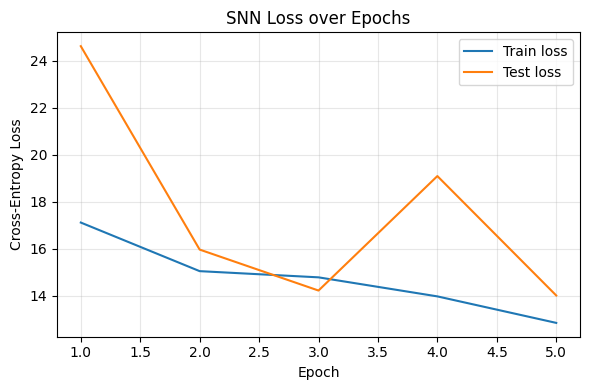

In [94]:
epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["test_loss"],  label="Test loss")
plt.title("SNN Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

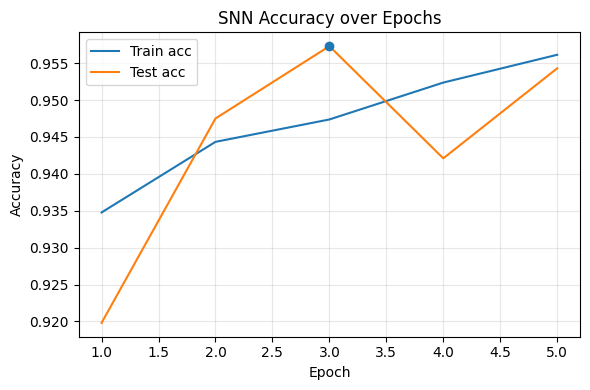

In [93]:
best_epoch_idx = int(np.argmax(history["test_acc"]))
best_epoch = best_epoch_idx + 1
best_test_acc = history["test_acc"][best_epoch_idx]

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["test_acc"],  label="Test acc")
plt.scatter([best_epoch], [best_test_acc], zorder=3)
plt.title("SNN Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()